In [ ]:
from datasets import load_dataset

ds = load_dataset("itsanmolgupta/mimic-cxr-dataset")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/357 [00:00<?, ?B/s]

data/train-00000-of-00002.parquet:   0%|          | 0.00/396M [00:00<?, ?B/s]

data/train-00001-of-00002.parquet:   0%|          | 0.00/397M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/30633 [00:00<?, ? examples/s]

Dataset Imported from Hugging Face

In [ ]:
import os
import math
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import timm
from transformers import AutoTokenizer, AutoModel

from datasets import load_dataset

# device
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cuda


In [ ]:
# inspect
print(ds)
print("Sample keys:", ds["train"].features.keys())
sample = ds["train"][0]
print("Types in the first sample:")
print(" - image:", type(sample["image"]))
print(" - findings:", type(sample["findings"]))
print(" - impression:", type(sample["impression"]))

DatasetDict({
    train: Dataset({
        features: ['image', 'findings', 'impression'],
        num_rows: 30633
    })
})
Sample keys: dict_keys(['image', 'findings', 'impression'])
Types in the first sample:
 - image: <class 'PIL.JpegImagePlugin.JpegImageFile'>
 - findings: <class 'str'>
 - impression: <class 'str'>


Checking the data imported and column names

In [ ]:
# combine fields into report (map on-the-fly in Dataset wrapper)
def combine_report(item):
    findings = item.get("findings") or ""
    impression = item.get("impression") or ""
    report = (findings + " " + impression).strip()
    if not report:
        report = "No findings reported."
    return report

# PyTorch Dataset wrapper (lazy access, one sample at a time)
from torchvision import transforms

image_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])

class HFToTorchDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.hf = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.hf)

    def __getitem__(self, idx):
        item = self.hf[idx]  # single row; lazy
        img = item["image"]
        # img is already PIL.Image in this dataset
        if self.transform is not None:
            img = self.transform(img)
        report = combine_report(item)
        return {"pixel_values": img, "report": report}

# Example: small dataloader (toy)
train_torch_ds = HFToTorchDataset(ds["train"], transform=image_transform)
small_dl = DataLoader(train_torch_ds, batch_size=4, shuffle=True, num_workers=2)
batch = next(iter(small_dl))
print("Batch pixel_values shape:", batch["pixel_values"].shape)
print("First report (truncated):", batch["report"][0][:200], "...")


Batch pixel_values shape: torch.Size([4, 3, 224, 224])
First report (truncated): Minimal left base atelectasis is seen. There is no focal consolidation, pleural effusion, or evidence of pneumothorax. The aorta remains calcified and tortuous. The cardiac silhouette is top-normal. N ...


In [ ]:
# instantiate ViT backbone (pretrained)
vit = timm.create_model('vit_base_patch16_224', pretrained=True)
vit.eval()
vit = vit.to(device)

# Check if model exposes forward_features
assert hasattr(vit, "forward_features"), "timm ViT must have forward_features()"

# text encoder
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
text_encoder = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT").to(device)
text_encoder.eval()


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [ ]:
class MedKLIPSimple(nn.Module):
    def __init__(self, img_dim=768, txt_dim=768, proj_dim=512):
        super().__init__()
        self.img_proj = nn.Linear(img_dim, proj_dim)
        self.txt_proj = nn.Linear(txt_dim, proj_dim)
        # temperature for contrastive
        self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1/0.07))

    def forward_image(self, x):
        """
        x: [B,3,H,W]
        returns:
            cls_feat: [B, img_dim]
            patch_feats: [B, P, img_dim]
        """
        feats = vit.forward_features(x)  # [B, num_tokens, dim]
        # CLS is token 0
        cls = feats[:, 0, :]            # [B, dim]
        patches = feats[:, 1:, :]       # [B, P, dim]
        return cls, patches

    def forward_text(self, texts):
        """
        texts: list[str] length B
        returns:
            cls_text: [B, txt_dim]
        """
        tok = tokenizer(texts, padding=True, truncation=True, return_tensors="pt").to(device)
        out = text_encoder(**tok)
        # CLS token embedding
        cls = out.last_hidden_state[:, 0, :]  # [B, txt_dim]
        return cls

    def compute_global_logits(self, img_cls, txt_cls):
        """
        project and compute logits matrix [B, B]
        """
        img_z = F.normalize(self.img_proj(img_cls), dim=-1)
        txt_z = F.normalize(self.txt_proj(txt_cls), dim=-1)
        logit_scale = self.logit_scale.exp()
        logits = logit_scale * (img_z @ txt_z.t())
        return logits, img_z, txt_z

model = MedKLIPSimple().to(device)


In [ ]:
def info_nce_loss(logits):
    """
    symmetric InfoNCE (like CLIP)
    logits: [B,B] image-to-text similarities (already scaled)
    """
    labels = torch.arange(logits.size(0), device=logits.device)
    loss_i = F.cross_entropy(logits, labels)
    loss_t = F.cross_entropy(logits.t(), labels)
    return (loss_i + loss_t) / 2


In [ ]:
# Training config
epochs = 10
batch_size = 8
train_loader = DataLoader(HFToTorchDataset(ds["train"], transform=image_transform),
                          batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

optimizer = torch.optim.AdamW(list(model.parameters()), lr=2e-5, weight_decay=1e-4)

model.train()
vit.eval()  # keep ViT backbone in eval if you want freezing; here we used pretrained vit frozen via eval
text_encoder.eval()  # we keep text_encoder frozen for speed; optionally unfreeze for fine-tuning

for epoch in range(epochs):
    running_loss = 0.0
    for step, batch in enumerate(train_loader):
        imgs = batch["pixel_values"].to(device)       # shape [B,3,224,224]
        reports = batch["report"]                     # list of strings length B

        # Forward image: obtain CLS and patches (no grad for vit if frozen)
        with torch.no_grad():
            img_cls, patch_feats = model.forward_image(imgs)  # img_cls [B,dim], patch_feats [B,P,dim]

        # Forward text (text encoder may be eval; the tokenizer + model run on device inside)
        with torch.no_grad():
            txt_cls = model.forward_text(reports)  # [B, txt_dim]

        # Compute logits & loss (model projections)
        logits, img_z, txt_z = model.compute_global_logits(img_cls.to(device), txt_cls.to(device))
        loss = info_nce_loss(logits)

        # Backprop only through projection layers
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if step % 10 == 0:
            print(f"Epoch {epoch} Step {step} Loss {loss.item():.4f}")
        # Demo limit so this runs fast for Colab prototyping
        if step >= 100:
            break

    avg = running_loss / (step + 1)
    print(f"Epoch {epoch} finished. Avg loss: {avg:.4f}")


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0 Step 0 Loss 2.1705
Epoch 0 Step 10 Loss 1.6149
Epoch 0 Step 20 Loss 2.0559
Epoch 0 Step 30 Loss 1.5602
Epoch 0 Step 40 Loss 1.9596
Epoch 0 Step 50 Loss 1.7444
Epoch 0 Step 60 Loss 1.7699
Epoch 0 Step 70 Loss 2.0577
Epoch 0 Step 80 Loss 1.7854
Epoch 0 Step 90 Loss 1.6978
Epoch 0 Step 100 Loss 2.0865
Epoch 0 finished. Avg loss: 1.8485
Epoch 1 Step 0 Loss 1.9947
Epoch 1 Step 10 Loss 1.6301
Epoch 1 Step 20 Loss 1.9927
Epoch 1 Step 30 Loss 1.7506
Epoch 1 Step 40 Loss 1.9494
Epoch 1 Step 50 Loss 1.9805
Epoch 1 Step 60 Loss 1.8673
Epoch 1 Step 70 Loss 1.6435
Epoch 1 Step 80 Loss 1.8448
Epoch 1 Step 90 Loss 1.7097
Epoch 1 Step 100 Loss 1.9967
Epoch 1 finished. Avg loss: 1.8042
Epoch 2 Step 0 Loss 1.7189
Epoch 2 Step 10 Loss 2.3608
Epoch 2 Step 20 Loss 2.0304
Epoch 2 Step 30 Loss 1.8706
Epoch 2 Step 40 Loss 1.5228
Epoch 2 Step 50 Loss 1.7713
Epoch 2 Step 60 Loss 1.4417
Epoch 2 Step 70 Loss 1.9137
Epoch 2 Step 80 Loss 1.6383
Epoch 2 Step 90 Loss 1.9061
Epoch 2 Step 100 Loss 1.6387
Epoch 

In [ ]:
# Utility to get image/global embedding and to get text embeddings
def encode_image(img_pil):
    model.eval()
    # transform and move
    img_tensor = image_transform(img_pil).unsqueeze(0).to(device)
    with torch.no_grad():
        img_cls, patch_feats = model.forward_image(img_tensor)
        img_proj = F.normalize(model.img_proj(img_cls), dim=-1)
    return img_proj.cpu().numpy(), patch_feats.cpu().numpy()  # patch_feats for grounding

def encode_texts(texts):
    model.eval()
    with torch.no_grad():
        txt_cls = model.forward_text(texts)  # [B, txt_dim] on device
        txt_proj = F.normalize(model.txt_proj(txt_cls), dim=-1)
    return txt_proj.cpu().numpy()

# example prompts
prompts = ["pneumonia", "pleural effusion", "cardiomegaly", "normal"]
# encode prompt embeddings
prompt_embs = encode_texts(prompts)  # shape [len(prompts), proj_dim]

# pick a sample image (lazy, safe)
sample_row = ds["train"][0]
img_pil = sample_row["image"]  # PIL.Image
img_emb, patch_feats = encode_image(img_pil)  # img_emb shape [1,proj_dim]

# cosine similarities
sims = (img_emb @ prompt_embs.T).squeeze()
best_idx = sims.argmax()
print("Zero-shot predicted:", prompts[best_idx], "score:", float(sims[best_idx]))


Zero-shot predicted: cardiomegaly score: 0.026530472561717033


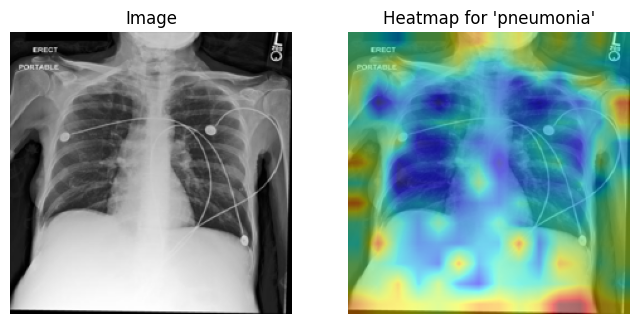

In [ ]:
import cv2

def patch_to_heatmap(patch_feats, text_proj, out_size=(224,224)):
    """
    patch_feats: [P, dim] (numpy) where P = num_patches (e.g., 196)
    text_proj: [dim] (numpy) target text projection vector (already normalized)
    return heatmap (H,W) in [0,1]
    """
    # Normalize
    p = patch_feats.copy()
    if p.ndim == 3:
        p = p[0]  # when shape [1, P, D]
    # project patch -> proj_dim via model.img_proj (use model.img_proj weights)
    # we will do it with torch for safety:
    p_t = torch.tensor(p, dtype=torch.float32).to(device)  # [P,D]
    with torch.no_grad():
        # map patches into proj space
        p_proj = model.img_proj(p_t)                       # [P,proj_dim]
        p_proj = F.normalize(p_proj, dim=-1).cpu().numpy() # [P,proj_dim]
    # cosine sim with text_proj
    sims = (p_proj @ text_proj.reshape(-1,1)).squeeze()  # [P]
    # reshape into grid
    P = sims.shape[0]
    g = int(math.sqrt(P))
    sims_grid = sims.reshape(g,g)
    # normalize
    sims_grid = (sims_grid - sims_grid.min()) / (sims_grid.max() - sims_grid.min() + 1e-8)
    # resize to out_size
    heat = cv2.resize(sims_grid, out_size)
    return heat

# visualize:
text_choice = "pneumonia"
text_proj = encode_texts([text_choice])[0]  # [proj_dim]
# get patch feats for our sample image
img_proj, patch_feats = encode_image(img_pil)  # patch_feats shape [1,P,D]
heat = patch_to_heatmap(patch_feats, text_proj, out_size=(224,224))

# overlay heatmap on image
img_np = np.array(img_pil.resize((224,224))).astype(np.uint8)
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(img_np)
plt.title("Image")
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(img_np, cmap='gray')
plt.imshow(heat, cmap='jet', alpha=0.5)
plt.title(f"Heatmap for '{text_choice}'")
plt.axis("off")
plt.show()


In [ ]:
# Save
torch.save(model.state_dict(), "medklip_projection_head.pth")

# Load (in a fresh session)
# model = MedKLIPSimple().to(device)
# model.load_state_dict(torch.load("medklip_projection_head.pth", map_location=device))


In [ ]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm


In [ ]:
# define the possible labels / zero-shot prompts
label_prompts = ["pneumonia", "pleural effusion", "cardiomegaly", "normal"]

# encode text prompts (static embeddings)
text_embs = encode_texts(label_prompts)  # shape [num_classes, proj_dim]
num_classes = len(label_prompts)


In [ ]:
# infer label heuristically based on text
def infer_true_label(report_text):
    text = report_text.lower()
    for i, label in enumerate(label_prompts):
        if label in text:
            return i
    return label_prompts.index("normal")  # default fallback

# evaluation dataloader
eval_loader = DataLoader(HFToTorchDataset(ds["train"], transform=image_transform),
                         batch_size=4, shuffle=True, num_workers=2, pin_memory=True)

# run evaluation
true_labels, pred_labels = [], []

model.eval()
for batch in tqdm(eval_loader, total=200, desc="Evaluating", leave=False):  # limit to 200 batches for quick test
    imgs = batch["pixel_values"].to(device)
    reports = batch["report"]

    with torch.no_grad():
        img_cls, _ = model.forward_image(imgs)
        img_proj = F.normalize(model.img_proj(img_cls), dim=-1)

    # compute cosine sim with each prompt embedding
    sims = img_proj.cpu().numpy() @ text_embs.T  # [B, num_classes]
    preds = sims.argmax(axis=1)

    for rep, p in zip(reports, preds):
        true_labels.append(infer_true_label(rep))
        pred_labels.append(p)

    if len(true_labels) >= 1000:  # evaluate on 1000 samples for speed
        break

true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)

print("✅ Evaluation completed on", len(true_labels), "samples.")


Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

✅ Evaluation completed on 1000 samples.


In [ ]:
acc = accuracy_score(true_labels, pred_labels)
prec, rec, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average='weighted')

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")

# detailed per-class report
print("\nDetailed Classification Report:")
print(classification_report(true_labels, pred_labels, target_names=label_prompts))


Accuracy: 0.3180
Precision: 0.3897
Recall: 0.3180
F1-score: 0.3237

Detailed Classification Report:
                  precision    recall  f1-score   support

       pneumonia       0.25      0.18      0.21       205
pleural effusion       0.51      0.27      0.35       507
    cardiomegaly       0.02      0.11      0.03        19
          normal       0.29      0.53      0.38       269

        accuracy                           0.32      1000
       macro avg       0.27      0.27      0.24      1000
    weighted avg       0.39      0.32      0.32      1000



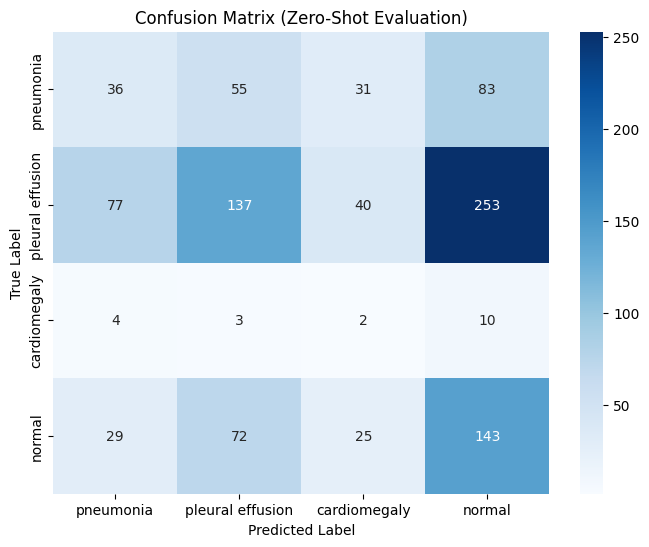

In [ ]:
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_prompts, yticklabels=label_prompts)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Zero-Shot Evaluation)")
plt.show()


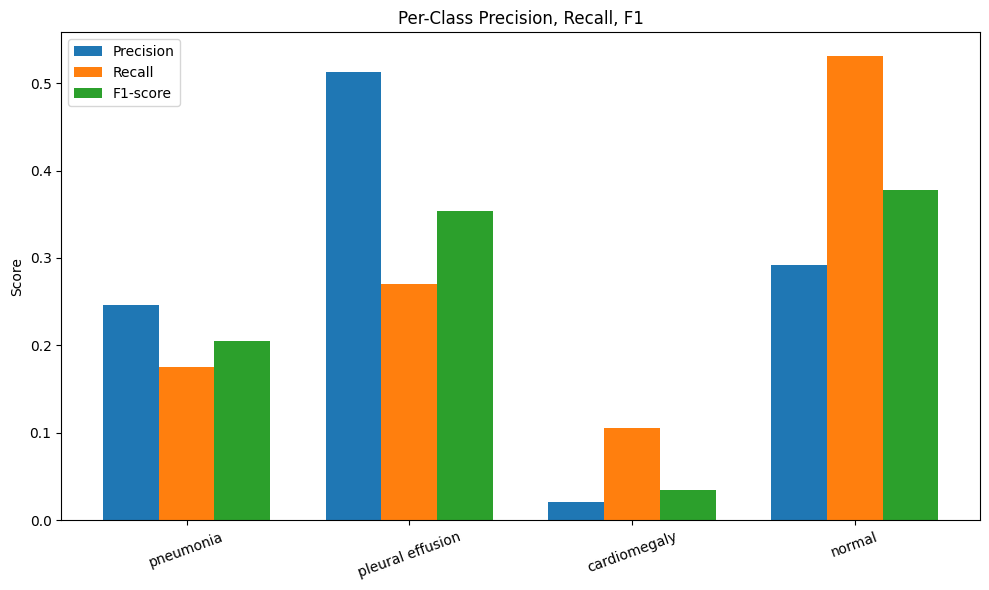

In [ ]:
# compute per-class metrics
precisions, recalls, f1s, _ = precision_recall_fscore_support(true_labels, pred_labels, average=None)

x = np.arange(len(label_prompts))
width = 0.25

plt.figure(figsize=(10,6))
plt.bar(x - width, precisions, width, label='Precision')
plt.bar(x, recalls, width, label='Recall')
plt.bar(x + width, f1s, width, label='F1-score')

plt.xticks(x, label_prompts, rotation=20)
plt.ylabel("Score")
plt.title("Per-Class Precision, Recall, F1")
plt.legend()
plt.tight_layout()
plt.show()


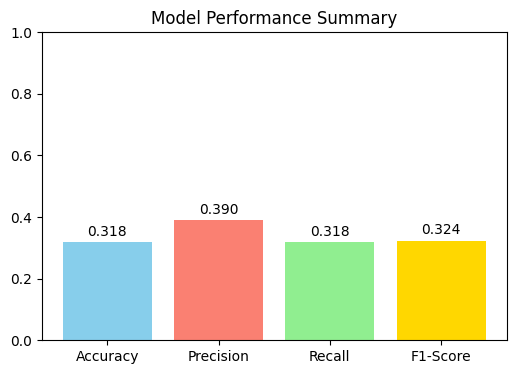

In [ ]:
summary_metrics = {
    "Accuracy": acc,
    "Precision": prec,
    "Recall": rec,
    "F1-Score": f1
}

plt.figure(figsize=(6,4))
plt.bar(summary_metrics.keys(), summary_metrics.values(), color=['skyblue', 'salmon', 'lightgreen', 'gold'])
plt.ylim(0, 1)
plt.title("Model Performance Summary")
for i, (k, v) in enumerate(summary_metrics.items()):
    plt.text(i, v + 0.02, f"{v:.3f}", ha='center', fontsize=10)
plt.show()
